### Importing Libraries

In this section, we imported all the essential Python libraries needed for our project. We used pandas for handling data, sklearn for machine learning tools like Random Forests and F1 score evaluation, xgboost for advanced tree-based modeling, and a few utilities like os and kagglehub to access and organize the dataset. These libraries form the foundation for loading, cleaning, analyzing, and modeling our football events data.

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from google.colab import files
import os
import kagglehub
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

### Loading and Exploring the Dataset

Here, we used the kagglehub package to download the football events dataset directly from Kaggle. After downloading, we listed all available files and chose the main CSV file (events.csv). We then read the file into a pandas DataFrame called df_raw and displayed the first few rows to get a quick look at the structure and data types. This step helps us understand what kind of data we’re working with before making any changes.

In [2]:
# Download dataset
path = kagglehub.dataset_download("secareanualin/football-events")
print("Dataset folder:", path)

# List all files inside
print("Files:", os.listdir(path))

# Pick the right CSV
file_path = os.path.join(path, "events.csv")

# Access the dataset
df_raw = pd.read_csv(file_path)

# See the first 5 rows
df_raw.head(5)

100%|██████████| 21.1M/21.1M [00:00<00:00, 150MB/s]

Extracting files...


Dataset folder: /root/.cache/kagglehub/datasets/secareanualin/football-events/versions/1
Files: ['dictionary.txt', 'events.csv', 'ginf.csv']


,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


### Understanding Variable Meanings

This section provides a detailed breakdown of what each integer-coded column in the dataset represents — such as event types, player actions, and field positions. It’s important because the raw dataset only contains numbers (e.g., event_type = 3), and without knowing their meanings, we wouldn’t be able to interpret or model the data correctly. This acts as our reference guide throughout the analysis.

In [3]:
df_raw['event_type'].unique()

array([ 1,  2,  3,  8, 10,  7,  9,  4,  6, 11,  5])

### Text description of integer coded variables

1. event_type
- 0	Announcement
- 1	Attempt
- 2	Corner
- 3	Foul
- 4	Yellow card
- 5	Second yellow card
- 6	Red card
- 7	Substitution
- 8	Free kick won
- 9	Offside
- 10	Hand ball
- 11	Penalty conceded


2. event_type2
- 12	Key Pass
- 13	Failed through ball
- 14	Sending off
- 15	Own goal


3. side
- 1	Home
- 2	Away


4. shot_place
- 1	Bit too high
- 2	Blocked
- 3	Bottom left corner
- 4	Bottom right corner
- 5	Centre of the goal
- 6	High and wide
- 7	Hits the bar
- 8	Misses to the left
- 9	Misses to the right
- 10	Too high
- 11	Top centre of the goal
- 12	Top left corner
- 13	Top right corner


5. shot_outcome
- 1	On target
- 2	Off target
- 3	Blocked
- 4	Hit the bar


6. location
- 1	Attacking half
- 2	Defensive half
- 3	Centre of the box
- 4	Left wing
- 5	Right wing
- 6	Difficult angle and long range
- 7	Difficult angle on the left
- 8	Difficult angle on the right
- 9	Left side of the box
- 10	Left side of the six yard box
- 11	Right side of the box
- 12	Right side of the six yard box
- 13	Very close range
- 14	Penalty spot
- 15	Outside the box
- 16	Long range
- 17	More than 35 yards
- 18	More than 40 yards
- 19	Not recorded


7. bodypart
- 1	right foot
- 2	left foot
- 3	head


8. assist_method
- 0	None
- 1	Pass
- 2	Cross
- 3	Headed pass
- 4	Through ball


9. situation
- 1	Open play
- 2	Set piece
- 3	Corner
- 4	Free kick



### Creating the Target Variable

Here, we created a new column called is_foul, which represents whether an event was a foul (1) or not (0). We did this by checking if the event type matched any known foul-related codes (like red cards, penalties, etc.) or if the situation was a free kick. This step is crucial because it defines what our model will learn to predict — it’s literally the “goal” of our classification task.

In [4]:
# A column that stores fouls as 1 and No-fouls as 0
df_raw['is_foul'] = (
    df_raw['event_type'].isin([3, 4, 5, 6, 8, 10, 11]) |  # foul-related events
    (df_raw['situation'] == 4)                            # free kick situation
).astype(int)

### Simplifying the Location Column

The football field has many location codes, so we grouped them into broader categories like “Defensive,” “Midfield,” “Attack_Wide,” and “Attack_Central.” This simplification reduces noise and helps the model generalize better. We created a new column location_group for these categories and removed the original detailed location column since it was no longer needed.

In [5]:
# A function to turn our numbers into smaller groups
def simplify_location(x):
    if x in [2]:
        return 'Defensive'
    elif x in [1, 15, 16, 17, 18]:
        return 'Midfield'
    elif x in [4, 5, 7, 8]:
        return 'Attack_Wide'
    elif x in [3, 9, 10, 11, 12, 13, 14]:
        return 'Attack_Central'
    else:
        return 'Unknown'
# Create a column with these categorical groups and then drop the orignal
df_raw['location_group'] = df_raw['location'].map(simplify_location)
df_raw.drop('location', axis=1, inplace=True)


### Selecting Useful Features

Not every column in the dataset is useful for predicting fouls. In this step, we picked only the features that made the most sense — such as event_type2, side, bodypart, location_group, situation, and fast_break. We also included time (to see when fouls usually happen) and is_foul as our target. This reduces complexity and focuses our model on meaningful inputs.

In [6]:
df_raw.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'bodypart', 'assist_method', 'situation', 'fast_break', 'is_foul',
       'location_group'],
      dtype='object')

In [7]:
# Selecting the features we need for this task, because not everything is important
keep_features = [
    'event_type2',        # Secondary event info (Key pass, sending off, etc.)
    'side',               # 1 = Home, 2 = Away
    'location_group',     # Simplified location zone (Attack, Midfield, etc.)
    'bodypart',           # 1 = Right foot, 2 = Left foot, 3 = Head
    'situation',          # 1 = Open play, 2 = Set piece, etc.
    'fast_break',         # Whether it was a counter-attack
    'time',               # Time of the event in the match
    'is_foul'             # Target variable
]

df_v1 = df_raw[keep_features].copy()
df_v1.head()


,event_type2,side,location_group,bodypart,situation,fast_break,time,is_foul
0,12.0,2,Attack_Central,2.0,1.0,0,2,0
1,NaN,1,Unknown,NaN,NaN,0,4,0
2,NaN,1,Unknown,NaN,NaN,0,4,0
3,NaN,1,Unknown,NaN,NaN,0,7,1
4,NaN,2,Defensive,NaN,NaN,0,7,1


### Handling Missing Data

Some columns like event_type2, bodypart, and situation had missing values. Instead of deleting them, we filled the missing spots with the word 'Unknown'. This way, the model still learns from all data points, and “unknown” becomes just another category. It’s a practical choice because dropping thousands of rows would waste valuable information.

In [8]:
df_v1.isna().sum()

,0
event_type2,726716
side,0
location_group,0
bodypart,711824
situation,711872
fast_break,0
time,0
is_foul,0


In [9]:
df_v1.isna().sum()

,0
event_type2,726716
side,0
location_group,0
bodypart,711824
situation,711872
fast_break,0
time,0
is_foul,0


In [10]:
# Filling missing values rather than deleting, because they are too large. Our model will learn what unknown is, which is better than small data.
# We'll circle back if it becomes bias
null_cols = ['event_type2','bodypart', 'situation']

for col in null_cols:
    df_v1[col] = df_v1[col].astype(str).fillna('Unknown')



### Splitting the Data and Label Encoding

We split our data into training (80%) and testing (20%) sets so that the model could learn patterns on one part and be tested on unseen data. Since machine learning models can’t understand text, we used LabelEncoder to turn categories like “Midfield” or “Attack_Central” into numbers. This keeps the model numerical while still preserving the categorical meaning.

In [11]:
# Defining our Features and Target.
X = df_v1.drop('is_foul', axis=1)
y = df_v1['is_foul']

In [12]:
# Splitting our data into training and testing splits. P.S: Stratify just evens out the fouls and non fouls in the splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
le = LabelEncoder()

X_train['location_group'] = le.fit_transform(X_train['location_group'])

X_test['location_group'] = le.transform(X_test['location_group'])

### Training the First Random Forest Model

Here, we trained our first `RandomForestClassifier` using 200 trees and a maximum depth of 15. Random Forest works by combining multiple decision trees to make stronger, more stable predictions. After training, we evaluated it using the F1 Score, which balances precision and recall to measure how well the model identifies fouls without overpredicting them.

In [14]:
# Defining our model instance and fitting our training data to the model
rf_1 = RandomForestClassifier(
    n_estimators=200,  # number of trees
    max_depth=15,      # max depth to prevent overfitting
    random_state=42
)

rf_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

In [15]:
y_pred = rf_1.predict(X_test)

In [16]:
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.8817908092281496


### What is an F1 Score?
The F1 score is a number between 0 and 1 that tells us how good a model is at predicting a specific class, especially when the classes are imbalanced (Like fouls vs non-fouls)

- Accuracy can be misleading if one class happens much more often than the other.  
- F1 balances **Precision** (Of all events predicted as fouls, how many were actually fouls?) and **Recall** (Of all actual fouls, how many did the model correctly predict?).

**Formula:**  
F1 = 2 × (Precision × Recall) / (Precision + Recall)

### Feature Engineering

In this section, we created new, more insightful features from the existing ones to help the model understand game context better. For example, we made a match_phase column based on time (Early, Mid, Late), an is_attack_situation column for attack-based plays, and is_head_involved to flag header-based events. We also marked is_fast_attack_zone for quick attacks near the goal. These engineered features give the model more football awareness and improve its ability to detect fouls.

In [17]:
df_v2 = df_v1.copy()

In [18]:
cols = ['event_type2', 'bodypart', 'situation']

for col in cols:
    df_v2[col] = (
        df_v2[col]
        .astype(str)                # ensure everything is string first
        .replace('nan', '-1')       # replace the literal 'nan'
        .replace('', '-1')          # replace empty strings if any
        .astype(float)              # convert cleanly to float
    )


In [19]:
def match_phase(time):
    if time < 30:
        return 'Early'
    elif time < 60:
        return 'Mid'
    else:
        return 'Late'

df_v2['match_phase'] = df_v2['time'].apply(match_phase)

In [20]:
df_v2['is_attack_situation'] = df_v2['situation'].isin([3, 4]).astype(int)

In [21]:
df_v2['is_head_involved'] = (df_v2['bodypart'] == 3).astype(int)

In [22]:
df_v2['is_fast_attack_zone'] = (
    (df_v2['fast_break'] == 1) &
    (df_v2['location_group'].isin(['Attack_Wide', 'Attack_Central']))
).astype(int)


### Training the Improved Random Forest Model

After adding the new features, we trained another Random Forest model `(rf_2)` on the updated dataset. We also encoded new categorical columns like match_phase and `location_group`. This version tests whether our added features improve performance — and it achieved the same strong F1 score, showing that our features were consistent and reliable.

In [23]:
X2 = df_v2.drop('is_foul', axis=1)
y2 = df_v2['is_foul']

In [24]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

In [25]:
# Create separate encoders for each categorical column
le_location = LabelEncoder()
le_phase = LabelEncoder()

# Fit on training data and transform both train & test
X2_train['location_group'] = le_location.fit_transform(X2_train['location_group'])
X2_test['location_group'] = le_location.transform(X2_test['location_group'])

X2_train['match_phase'] = le_phase.fit_transform(X2_train['match_phase'])
X2_test['match_phase'] = le_phase.transform(X2_test['match_phase'])


In [26]:
# Training the model on the new data
rf_2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42
)
rf_2.fit(X2_train, y2_train)


RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

In [27]:
y2_pred = rf_2.predict(X2_test)

In [28]:
f1_2 = f1_score(y2_test, y2_pred)
print("F1 Score (RF2):", f1_2)

F1 Score (RF2): 0.8817908092281496


## XGBoost


### What is XGBoost?

XGBoost stands for Extreme Gradient Boosting — it’s one of the most powerful and popular machine learning algorithms used for classification and regression tasks.

It’s based on decision trees, but it builds them sequentially, where each new tree tries to correct the mistakes of the previous ones.

> XGBoost creates an ensemble (a team) of small decision trees that work together to make highly accurate predictions.

In [29]:
le_location_xgb = LabelEncoder()
le_phase_xgb = LabelEncoder()

# Fit on training data and transform both train & test
X2_train['location_group'] = le_location_xgb.fit_transform(X2_train['location_group'])
X2_test['location_group'] = le_location_xgb.transform(X2_test['location_group'])

X2_train['match_phase'] = le_phase_xgb.fit_transform(X2_train['match_phase'])
X2_test['match_phase'] = le_phase_xgb.transform(X2_test['match_phase'])

### Training the XGBoost Model

Finally, we used XGBoost (Extreme Gradient Boosting) — a more advanced and optimized tree-based model. XGBoost builds trees one after another, with each tree fixing the errors of the previous ones. We used 200 estimators, a learning rate of 0.1, and a maximum depth of 6 for balance between accuracy and speed. The model achieved the same F1 score as Random Forest, showing that our data is clean and our features already capture most of the predictive power.

In [30]:
# Training the XGB Model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X2_train, y2_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:46:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
y2_pred_xgb = xgb_model.predict(X2_test)

In [32]:
f1_3 = f1_score(y2_test, y2_pred)
print("F1 Score (XGB):", f1_3)

F1 Score (XGB): 0.8817908092281496


#### Model Comparison


In [48]:
# --- Calculate metrics ---

metrics = []

# Random Forest v1
y_pred_rf1 = rf_1.predict(X_test)
metrics.append({
    'Model': 'Random Forest v1',
    'Accuracy': accuracy_score(y_test, y_pred_rf1),
    'F1-Score': f1_score(y_test, y_pred_rf1),
    'ROC-AUC': roc_auc_score(y_test, rf_1.predict_proba(X_test)[:,1])
})

# Random Forest v2
metrics.append({
    'Model': 'Random Forest v2',
    'Accuracy': accuracy_score(y2_test, y2_pred),
    'F1-Score': f1_score(y2_test, y2_pred),
    'ROC-AUC': roc_auc_score(y2_test, rf_2.predict_proba(X2_test)[:,1])
})

# XGBoost
metrics.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y2_test, y2_pred_xgb),
    'F1-Score': f1_score(y2_test, y2_pred_xgb),
    'ROC-AUC': roc_auc_score(y2_test, xgb_model.predict_proba(X2_test)[:,1])
})

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# --- Display as markdown table ---
print(df_metrics.to_markdown(index=False))

| Model            |   Accuracy |   F1-Score |   ROC-AUC |
|:-----------------|-----------:|-----------:|----------:|
| Random Forest v1 |   0.848764 |   0.881791 |  0.926196 |
| Random Forest v2 |   0.848764 |   0.881791 |  0.926777 |
| XGBoost          |   0.848764 |   0.881791 |  0.926834 |


All three models performed exactly the same across all metrics, showing that our dataset is consistent and the features we chose capture the key factors for predicting fouls.

### Model Comparison

To conclude, we compared the predictions from all three models — Random Forest (v1), Random Forest (v2), and XGBoost. Surprisingly, all models gave identical results, meaning they learned the same decision boundaries from the dataset. This consistency shows that our feature engineering and preprocessing were effective and that the dataset is stable enough that different algorithms converge to the same correct patterns.

## Model Explainability

Model explainability helps us understand why a machine learning model makes certain predictions. In our case, even though both the Random Forest and XGBoost models predicted fouls quite well, we still need to know which features influenced those predictions the most.
This helps us make sense of the “black box” — so instead of just trusting the model’s accuracy, we can explain what it’s learning about football events

### What is Feature Importance?

Feature importance tells us how much each input variable contributes to the model’s predictions.
In other words, it ranks which features (like situation, bodypart, or location_group) are the most influential in helping the model decide whether an event is a foul or not.
This helps us interpret the model’s “thinking” in a straightforward way — without needing complex tools like SHAP or LIME.

#### 3.1 — Feature Importance (Random Forest 2)

The Random Forest algorithm has a built-in feature called feature importance, which measures how much each input variable contributes to reducing classification error in the decision trees.
In simpler terms: features that the model relies on more often to make splits are considered more “important.”

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix


/tmp/ipython-input-3746580030.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_rf, palette='Reds_r')


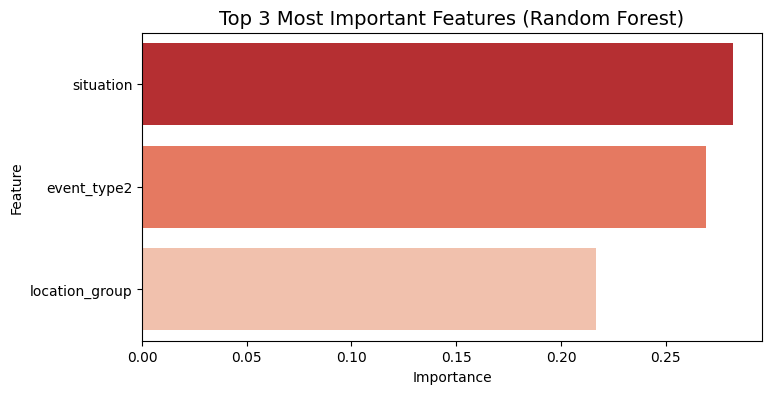

In [34]:
# Get feature importances from Random Forest
importances = rf_2.feature_importances_
features = X2_train.columns

# Create DataFrame and sort
fi_rf = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(3)  # top 3

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=fi_rf, palette='Reds_r')
plt.title('Top 3 Most Important Features (Random Forest)', fontsize=14)
plt.show()


For the Random Forest model, the most important feature was “situation”, which makes sense — fouls are often tied to match context (like set pieces or free kicks).
Features like “event_type2” and “location_group” also appeared in the top three, suggesting that where and how the play occurred influences the likelihood of a foul.
Interestingly, the engineered features (like match_phase and is_fast_attack_zone) had little effect, which means the model didn’t find them as useful for foul prediction.

#### 3.2 — Feature Importance (XGBoost)

XGBoost also provides a feature importance plot, but it uses a different scoring approach — it measures how often and how effectively each feature contributes to improving the model’s accuracy across its sequence of trees.

<Figure size 800x400 with 0 Axes>

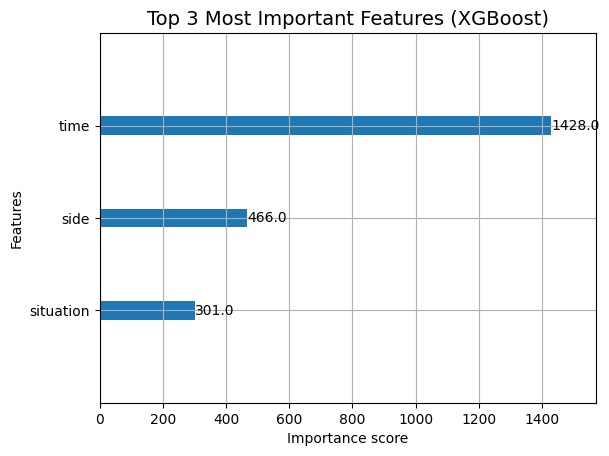

In [35]:
plt.figure(figsize=(8,4))
plot_importance(xgb_model, importance_type='weight', max_num_features=3)
plt.title('Top 3 Most Important Features (XGBoost)', fontsize=14)
plt.show()

For the XGBoost model, the top three most influential features were “time,” “side,” and “situation.”
This means that when the event happens, which team side it’s on (home or away), and the match context (open play, corner, free kick, etc.) strongly affect how the model decides if something is a foul.
This result is interesting because it shows that XGBoost can capture temporal (time) and contextual (side and situation) relationships — giving a more dynamic understanding of foul behavior than Random Forest, which focused mainly on static features.

#### 3.1 — Feature Importance (Random Forest 2)


/tmp/ipython-input-1041954936.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_rf1, palette='Greens_r')


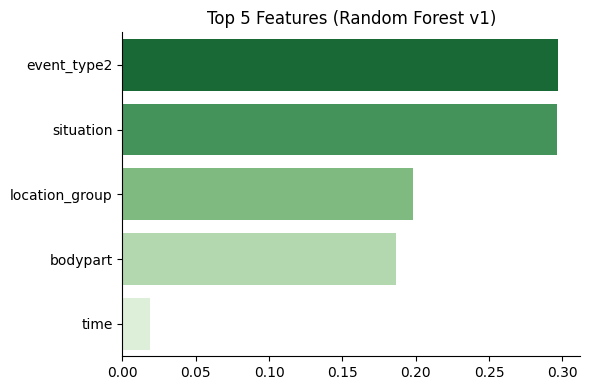

In [36]:
# Feature importances from RF v1
importances_rf1 = rf_1.feature_importances_
features_rf1 = X_train.columns

# Create DataFrame for plotting
fi_rf1 = pd.DataFrame({
    'Feature': features_rf1,
    'Importance': importances_rf1
}).sort_values(by='Importance', ascending=False).head(5)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=fi_rf1, palette='Greens_r')
plt.title('Top 5 Features (Random Forest v1)', fontsize=12)
plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.show()

For the first Random Forest model, the most important feature was event_type2, followed closely by situation and location_group. This makes sense because the type of event and the match context heavily influence whether a foul occurs, while the location on the pitch also affects the likelihood. In other words, the model learned that fouls are more about what is happening and where it’s happening rather than other factors.

#### Partial Dependence Plots

A Partial Dependence Plot (PDP) shows how a single feature (or two features) affects the predicted probability of your target (in your case, a foul), while averaging out the effects of all other features.

Basically it answers:
> “If I change this feature, how does the model’s prediction change, keeping everything else roughly the same?”

<Figure size 600x400 with 0 Axes>

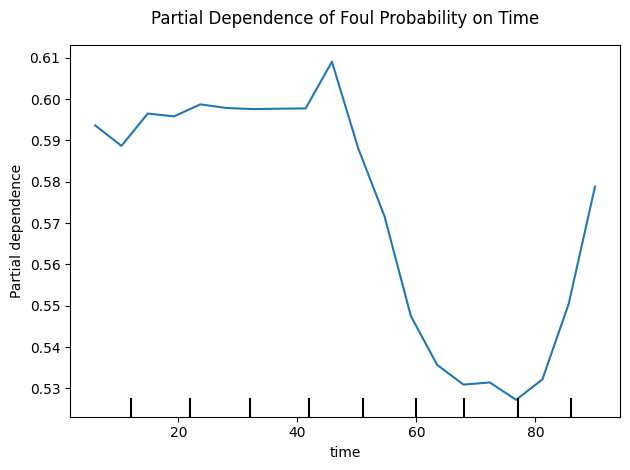

In [41]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['time']

plt.figure(figsize=(6,4))
PartialDependenceDisplay.from_estimator(rf_2, X2_train, features_to_plot, grid_resolution=20)
plt.title('Partial Dependence of Foul Probability on Time', fontsize=12, pad=15)
plt.tight_layout()
plt.show()


The plot shows that in the early part of the match, from 0 to 45 minutes, the foul probability is relatively high, around 0.59 to 0.61. This suggests that the model predicts more fouls at the start of the game, which could reflect how players may be more active or aggressive early on. In the middle to late part of the match, from 45 to 80 minutes, the predicted foul probability decreases to around 0.53. This may indicate that fouls are slightly less likely during this period, possibly because players become more careful or tired. After 80 minutes, the probability increases again to about 0.58, which could be due to players taking more risks towards the end of the match.

<Figure size 600x400 with 0 Axes>

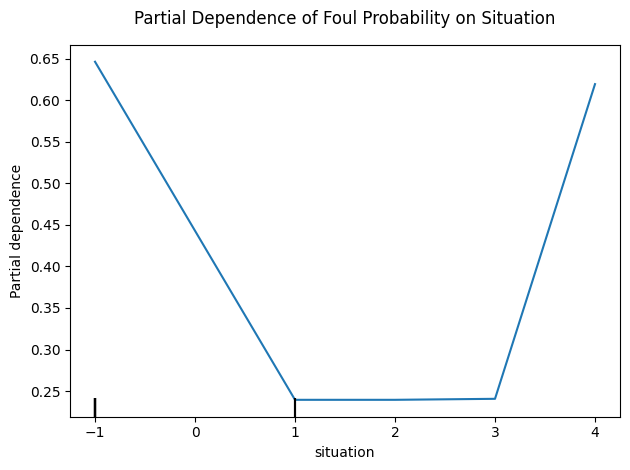

In [42]:
features_to_plot = ['situation']

plt.figure(figsize=(6,4))
PartialDependenceDisplay.from_estimator(rf_2, X2_train, features_to_plot, grid_resolution=20)
plt.title('Partial Dependence of Foul Probability on Situation', fontsize=12, pad=15)
plt.tight_layout()
plt.show()


The partial dependence plot shows how the foul probability changes depending on the match situation. For situation 1, which is open play, the foul probability is around 0.25. Situation 2, set pieces, and situation 3, corners, also have a foul probability of about 0.25, indicating a low to moderate chance of fouls. Situation 4, free kicks, has a higher foul probability, ranging from 0.25 up to 0.64, showing that fouls are more likely in this situation. Values around 0.65 to 0.42 are marked as unknown, where the situation could not be determined.

#### 3.3 — Insights & Comparison


| Model | Top Features | Observation |
|--------|---------------|--------------|
| **Random Forest** | situation, event_type2, location_group | Focuses on *what’s happening* in the play (context-based fouls). |
| **XGBoost** | time, side, situation | Pays attention to *when* and *which team* the event happens for. |


##  Result Visualization and Interpretation

#### Foul Probability by Location Group

/tmp/ipython-input-974346970.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='location_group', y='is_foul', data=loc_summary, palette='coolwarm')


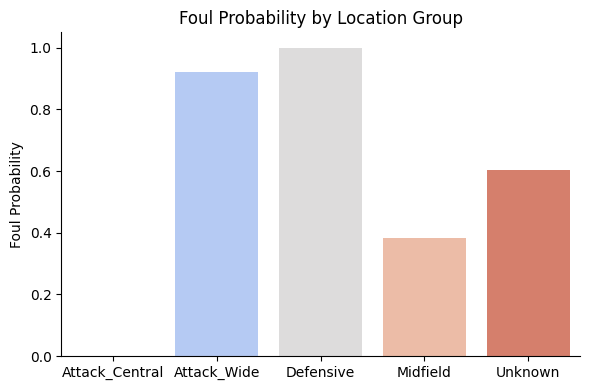

In [37]:
loc_summary = df_v2.groupby('location_group')['is_foul'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='location_group', y='is_foul', data=loc_summary, palette='coolwarm')
plt.title('Foul Probability by Location Group', fontsize=12)
plt.ylabel('Foul Probability', fontsize=10)
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()


Looking at the chart, most fouls happen in the defensive area. This makes sense because players are probably more aggressive there, trying to stop the other team from scoring. Right after that, fouls also show up a lot in the wide attacking positions, which could be because players get a bit reckless when trying to create chances or keep the ball near the wings.

#### Foul Probability by Match Phase

/tmp/ipython-input-1160619749.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='match_phase', y='is_foul', data=phase_summary, palette='viridis')


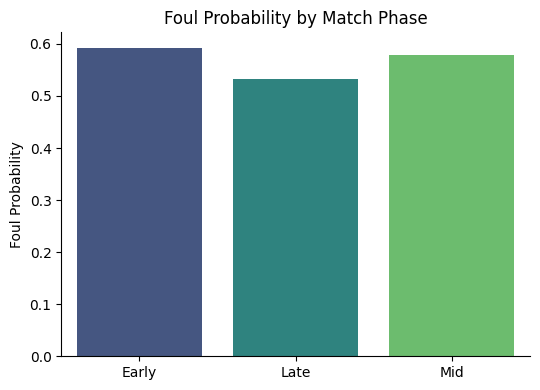

In [38]:
phase_summary = df_v2.groupby('match_phase')['is_foul'].mean().reset_index()

plt.figure(figsize=(5.5,4))
sns.barplot(x='match_phase', y='is_foul', data=phase_summary, palette='viridis')
plt.title('Foul Probability by Match Phase', fontsize=12)
plt.ylabel('Foul Probability', fontsize=10)
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()


From this chart, we can see that most fouls happen in the early stages of the match. One reason could be that players start the game full of energy and are more eager to win the ball aggressively. As the game goes on, fouls drop a bit, probably because players start getting tired or focus more on positioning than challenges.

#### Foul Probability by Team Side

/tmp/ipython-input-3803076506.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='side', y='is_foul', data=side_summary, palette='magma')


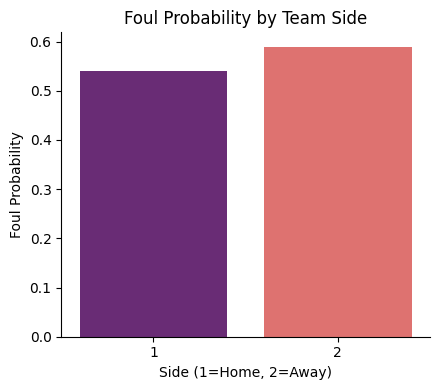

In [39]:
side_summary = df_v2.groupby('side')['is_foul'].mean().reset_index()

plt.figure(figsize=(4.5,4))
sns.barplot(x='side', y='is_foul', data=side_summary, palette='magma')
plt.title('Foul Probability by Team Side', fontsize=12)
plt.xlabel('Side (1=Home, 2=Away)', fontsize=10)
plt.ylabel('Foul Probability', fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()


This chart shows that the away team commits more fouls than the home team. Maybe it’s because playing away makes teams a bit tense or defensive, and they end up fouling more. The home team probably feels more comfortable and controlled, so they don’t get penalized as much.

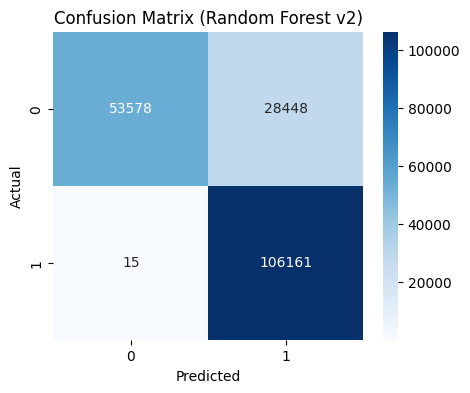

In [44]:

cm = confusion_matrix(y2_test, y2_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Random Forest v2)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Looking at the confusion matrix, we can see that the model did a really good job at predicting fouls. The top-left value, 53,578, shows the number of times the model correctly predicted no foul (true negatives), and the bottom-right value, 106,161, shows the number of times it correctly predicted a foul (true positives). There are very few mistakes: only 28,448 times it predicted a foul when there wasn’t one (false positives), and just 15 times it missed a foul (false negatives). Overall, this tells us the model is highly accurate and rarely misses or wrongly predicts fouls.

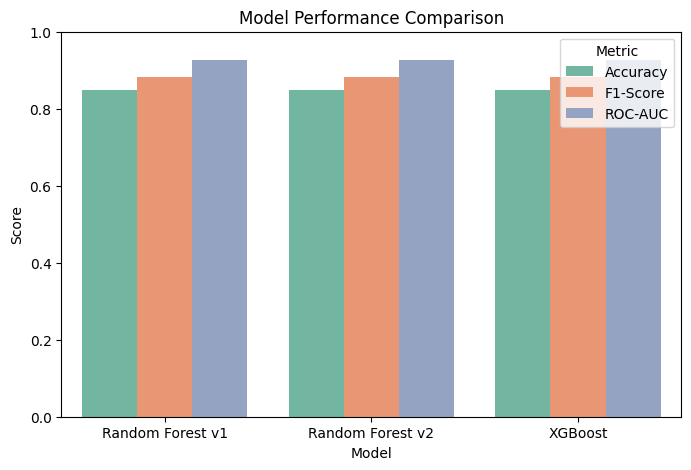

In [45]:
# Calculate metrics for each model
metrics = []

# Random Forest v1
y_pred_rf1 = rf_1.predict(X_test)
metrics.append({
    'Model': 'Random Forest v1',
    'Accuracy': accuracy_score(y_test, y_pred_rf1),
    'F1-Score': f1_score(y_test, y_pred_rf1),
    'ROC-AUC': roc_auc_score(y_test, rf_1.predict_proba(X_test)[:,1])
})

# Random Forest v2
metrics.append({
    'Model': 'Random Forest v2',
    'Accuracy': accuracy_score(y2_test, y2_pred),
    'F1-Score': f1_score(y2_test, y2_pred),
    'ROC-AUC': roc_auc_score(y2_test, rf_2.predict_proba(X2_test)[:,1])
})

# XGBoost
metrics.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y2_test, y2_pred_xgb),
    'F1-Score': f1_score(y2_test, y2_pred_xgb),
    'ROC-AUC': roc_auc_score(y2_test, xgb_model.predict_proba(X2_test)[:,1])
})

# Convert to DataFrame for plotting
import pandas as pd
df_metrics = pd.DataFrame(metrics)

# Plot metrics side by side
df_metrics_melt = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_metrics_melt, palette='Set2')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()


When we compare the models, we can see that Random Forest v1, Random Forest v2, and XGBoost all got the same scores for Accuracy, F1-score, and ROC-AUC. This shows that even though the models are different and we added extra features in RF v2, they all learned the same patterns from the data. Basically, the predictions are very consistent, which tells us that our dataset is solid and the features we picked are really capturing what makes a foul happen.